In [2]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys

if "../" not in sys.path:
  sys.path.append("../") 

from collections import defaultdict
from envs.windy_gridworld import WindyGridworldEnv
from common import plotting

matplotlib.style.use('ggplot')

In [3]:
env = WindyGridworldEnv()

In [4]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    给定一个Q函数和epsilon，构建一个ε-贪婪的策略
    
    参数:
        Q: 一个dictionary其key-value是state -> action-values.
            key是状态s，value是一个长为nA(Action个数)的numpy数组，表示采取行为a的概率。
        epsilon:  float 
        nA: action的个数
    
    返回值:
        返回一个 函数，这个函数的输入是一个状态/观察(observation)，输出是一个长度为nA的numpy数组，表示采取不同Action的概率

    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [5]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    SARSA 算法: On-policy TD控制。找到最优的ε-greedy 策略。
    
    参数:
        env: OpenAI 环境。
        num_episodes: 采样的episodes次数。
        discount_factor: 打折因子。
        alpha: TD学习率(learning rate)。
        epsilon:  ε-贪婪的ε，随机行为的概率
    
    返回值:
         二元组(Q, stats).
        Q 是最优行为价值函数，一个dictionary state -> action values.
        stats是一个EpisodeStats对象，这个对象有两个numpy数值，分别是episode_lengths和episode_rewards，存储每个Episode的长度和奖励，用于绘图。
    """
    
    # 最终返回的Q(s,a)函数The final action-value function。
    # 它是一个嵌套的dictionary state -> (action -> action-value)。
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # 参考返回值的注释。
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # 通过Q(s,a)得到ε-贪婪的策略，注意Q变化后策略就随着改变了。
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # 重置环境并且采样第一个Action
        state = env.reset()
        action_probs = policy(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        for t in itertools.count():
            # 采取行为A
            next_state, reward, done, _ = env.step(action)
            
            # 选择下一个行为A'
            next_action_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)
            
            # 更新统计信息
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            td_target = reward + discount_factor * Q[next_state][next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
    
            if done:
                break
                
            action = next_action
            state = next_state        
    
    return Q, stats

In [6]:
Q, stats = sarsa(env, 200)

Episode 200/200.

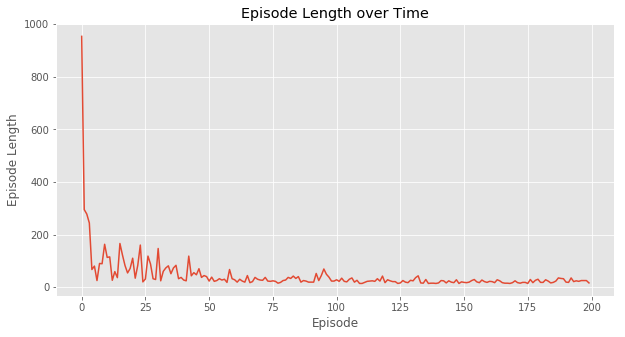

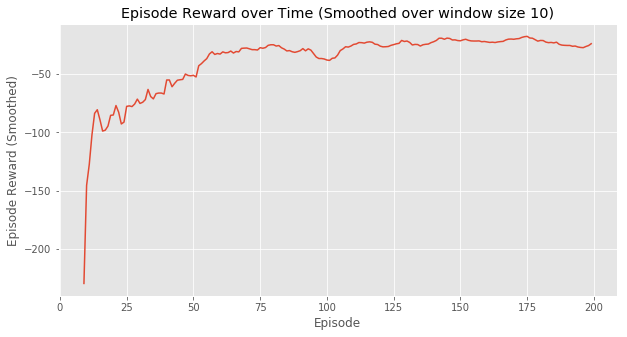

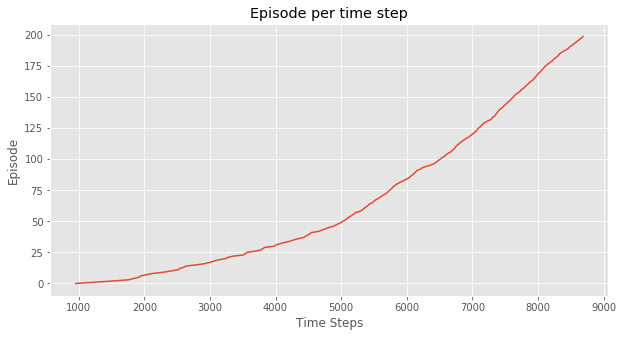

(<matplotlib.figure.Figure at 0x7fef9cdf4d30>,
 <matplotlib.figure.Figure at 0x7fef9cde0cc0>)

In [7]:
plotting.plot_episode_stats(stats)